# Computing PET

In [1]:
import calendar
from pathlib import Path

import pandas as pd
import xarray as xr

import hydrosignatures as hsg
import pydaymet as daymet
from pygeohydro import NWIS
from pynhd import WaterData

`PyDaymet` offers three methods for computing PET: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's validate its PET estimation methods with long-term mean monthly PET measurement from [TexasET Network](https://texaset.tamu.edu) for Houston, TX.

We choose station ID of 08071000 and time period of 2000-2009.

In [2]:
station = "08071000"
dates = ("2000-01-01", "2009-01-12")
root = Path("input_data")

In [3]:
clm_par = Path(root, f"{station}_clm_single_pixel.parquet")
clm_nc = Path(root, f"{station}_clm_basin.nc")

site = NWIS().get_info({"site": station})
coords = site[["dec_long_va", "dec_lat_va"]].iloc[0].to_list()

if clm_par.exists() and clm_nc.exists():
    clm_c = pd.read_parquet(clm_par)
    clm_b = xr.open_dataset(clm_nc, decode_coords="all", engine="h5netcdf")
else:
    variables = ("prcp", "tmin", "tmax", "srad", "dayl")
    clm_c = daymet.get_bycoords(tuple(coords), dates, variables=variables)
    clm_c.to_parquet(clm_par)

    wd = WaterData("gagesii_basins")
    basin = wd.byid("gage_id", station)
    clm_b = daymet.get_bygeom(basin.geometry.iloc[0], dates, variables=variables)
    clm_b.to_netcdf(clm_nc)

Next, we get the long-term mean monthly PET records for Houston, TX, from TexasET Network.

In [4]:
eto_obs = pd.Series(
    [2.36, 2.83, 4.32, 5.01, 6.11, 6.57, 6.52, 6.08, 5.57, 4.28, 2.90, 2.35],
    index=range(1, 13),
)
eto_obs.index.name = "month"
month_abbr = dict(enumerate(calendar.month_abbr))
eto_obs.index = eto_obs.index.map(month_abbr)
# convert to mm/month from in./month
eto_obs = eto_obs * 25.4

Now, let's compute PET using three methods by PyDaymet.

In [5]:
single, gridded, style = {}, {}, {}
methods = {"HS": "hargreaves_samani", "PM": "penman_monteith", "PT": "priestley_taylor"}
clm_b = daymet.potential_et(clm_b, method="penman_monteith")
for n, m in methods.items():
    pet_c = daymet.potential_et(clm_c, coords, method=m)
    single[f"{n} (Single Pixel)"] = pet_c["pet (mm/day)"]
    style[f"{n} (Single Pixel)"] = "-"
    pet_b = daymet.potential_et(clm_b, method=m)
    gridded[f"{n} (Areal Average)"] = pet_b.pet.mean(dim=["x", "y"]).values.flatten()
    style[f"{n} (Areal Average)"] = "--"
style["TexasET"] = "-"

Finally, let's compute mean monthly PET for each method and compare with the long-term mean monthly PET records. For computing mean monthly PET from daily we use HyRiver's [HydroSignatures](https://docs.hyriver.io/readme/hydrosignatures.html) package.

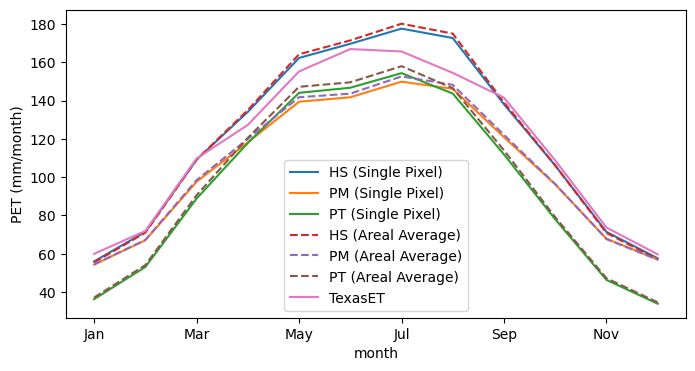

In [6]:
mean_month = hsg.mean_monthly(pd.DataFrame({**single, **gridded}), index_abbr=True)
mean_month["TexasET"] = eto_obs
ax = mean_month.plot(figsize=(8, 4), ylabel="PET (mm/month)", style=style)
ax.figure.savefig(
    Path("_static", "pet_validation.png"), dpi=300, bbox_inches="tight", facecolor="w"
)

The plots show that the Hargreaves-Samani method produces better results for this location. However, we should note that for arid regions, the Priestley-Taylor and Penman-Monteith methods require a correction factor to account for the fact that in arid regions, the air might not be saturated when its temperature is at its minimum. PyDaymet, has an additional parameter called `arid_correction` for this purpose. For more information, please refer to [PyDaymet documentation](https://docs.hyriver.io/readme/pydaymet.html). Now that we know that the Hargreaves-Samani method produces better results for this location, we can use it to compute aridity index and ensure that Houston is humid and does not require the arid correction factor.

In [7]:
ai = hsg.aridity_index(single["HS (Single Pixel)"], clm_c["prcp (mm/day)"])
1 / ai

0.9231323220526481

Note that `compute_ai` calculates PET / Prcp, so in order to use the UNEP's aridity classification table, we need to consider the inverse of this value. Considering that 0.65 is the threshold for aridity, we can conclude that Houston is humid and there is no need for the arid correction factor.